Total documents: 1977
Classes: ['rec.autos', 'sci.space']
Train size: 1186
Validation size: 395
Test size: 396
Vocabulary size: 16935
Number of rare features (df <= 2): 11820
Example rare tokens: ['00000' '00043819' '0004847546' '0004988' '0005' '000mi' '000miles'
 '000th' '0012' '0018']
Validation documents with rare tokens: 334/395
Test documents with rare tokens: 338/396

Training models with different Laplace smoothing (alpha):
  Training alpha = 1e-05
  Training alpha = 0.001
  Training alpha = 0.01
  Training alpha = 0.1
  Training alpha = 1.0
  Training alpha = 10.0

Summary of validation performance by alpha
--------------------------------------------------------------------------------------
     alpha | Val acc | Val F1 (macro) | Val log loss | Val F1 rare
--------------------------------------------------------------------------------------
     1e-05 | 0.9291 | 0.9291 | 0.8517 | 0.9519
     0.001 | 0.9291 | 0.9291 | 0.5355 | 0.9519
      0.01 | 0.9316 | 0.9316 | 0.3920 | 0

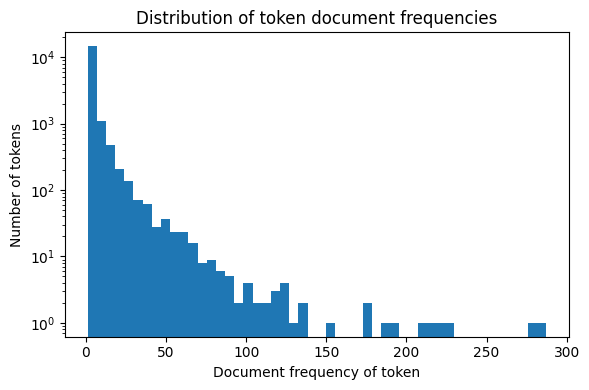

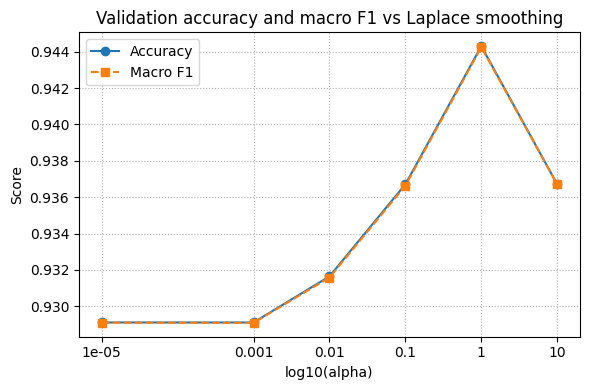

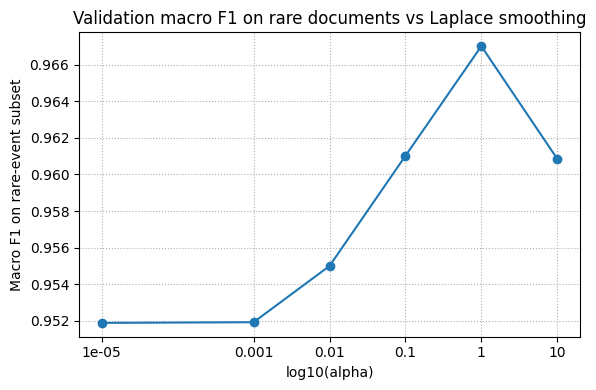

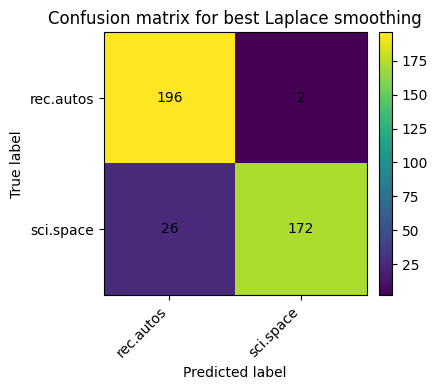

In [1]:
# Naive Bayes — Effect of Laplace Smoothing on Rare Events
# Technique: Multinomial Naive Bayes
# Internal focus: Smoothing parameter (alpha)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    log_loss,
    confusion_matrix,
    classification_report
)

# -------------------------------------------------------------------
# 1. Load a text dataset with naturally rare events (20 Newsgroups)
# -------------------------------------------------------------------
categories = ['rec.autos', 'sci.space']
data = fetch_20newsgroups(
    subset='all',
    categories=categories,
    remove=('headers', 'footers', 'quotes')
)

texts = np.array(data.data)
y = np.array(data.target)
target_names = data.target_names

print(f"Total documents: {len(texts)}")
print(f"Classes: {target_names}")

# -------------------------------------------------------------------
# 2. Train / validation / test split on raw text
# -------------------------------------------------------------------
X_train_text, X_temp_text, y_train, y_temp = train_test_split(
    texts, y, test_size=0.4, random_state=42, stratify=y
)
X_val_text, X_test_text, y_val, y_test = train_test_split(
    X_temp_text, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train size: {len(X_train_text)}")
print(f"Validation size: {len(X_val_text)}")
print(f"Test size: {len(X_test_text)}")

# -------------------------------------------------------------------
# 3. Vectorise text using word counts (sparse, many rare tokens)
# -------------------------------------------------------------------
vectorizer = CountVectorizer(
    stop_words='english',
    min_df=1  # keep all tokens to expose rare events
)

X_train = vectorizer.fit_transform(X_train_text)
X_val = vectorizer.transform(X_val_text)
X_test = vectorizer.transform(X_test_text)

vocab = np.array(vectorizer.get_feature_names_out())
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

# -------------------------------------------------------------------
# 4. Identify rare features based on document frequency
#    "Rare" = appears in at most 'rare_df_threshold' training documents
# -------------------------------------------------------------------
df = np.asarray((X_train > 0).sum(axis=0)).ravel()
rare_df_threshold = 2
rare_mask = df <= rare_df_threshold
num_rare_features = rare_mask.sum()

print(f"Number of rare features (df <= {rare_df_threshold}): {num_rare_features}")
print("Example rare tokens:", vocab[rare_mask][:10])

# Masks for validation and test documents that contain at least one rare token
val_has_rare = (X_val[:, rare_mask].sum(axis=1).A.ravel() > 0)
test_has_rare = (X_test[:, rare_mask].sum(axis=1).A.ravel() > 0)

print(f"Validation documents with rare tokens: {val_has_rare.sum()}/{len(val_has_rare)}")
print(f"Test documents with rare tokens: {test_has_rare.sum()}/{len(test_has_rare)}")

# -------------------------------------------------------------------
# 5. Train Multinomial Naive Bayes with different alphas
# -------------------------------------------------------------------
alphas = [1e-5, 1e-3, 1e-2, 1e-1, 1.0, 10.0]
results = []

print("\nTraining models with different Laplace smoothing (alpha):")
for alpha in alphas:
    print(f"  Training alpha = {alpha}")
    clf = MultinomialNB(alpha=alpha)
    clf.fit(X_train, y_train)

    # Validation predictions
    val_proba = clf.predict_proba(X_val)
    val_pred = clf.predict(X_val)

    # Global metrics
    acc = accuracy_score(y_val, val_pred)
    f1_macro = f1_score(y_val, val_pred, average='macro')
    ll = log_loss(y_val, val_proba)

    # Metrics restricted to documents that contain at least one rare token
    if val_has_rare.sum() > 0:
        val_proba_rare = val_proba[val_has_rare]
        val_pred_rare = val_pred[val_has_rare]
        y_val_rare = y_val[val_has_rare]

        acc_rare = accuracy_score(y_val_rare, val_pred_rare)
        f1_macro_rare = f1_score(y_val_rare, val_pred_rare, average='macro')
        ll_rare = log_loss(y_val_rare, val_proba_rare)
    else:
        acc_rare = np.nan
        f1_macro_rare = np.nan
        ll_rare = np.nan

    results.append({
        "alpha": alpha,
        "val_acc": acc,
        "val_f1_macro": f1_macro,
        "val_log_loss": ll,
        "val_acc_rare": acc_rare,
        "val_f1_macro_rare": f1_macro_rare,
        "val_log_loss_rare": ll_rare
    })

# -------------------------------------------------------------------
# 6. Print validation summary table
# -------------------------------------------------------------------
print("\nSummary of validation performance by alpha")
print("-" * 86)
print(f"{'alpha':>10} | {'Val acc':>7} | {'Val F1 (macro)':>14} | {'Val log loss':>12} | "
      f"{'Val F1 rare':>11}")
print("-" * 86)
for r in results:
    print(f"{r['alpha']:>10} | "
          f"{r['val_acc']:.4f} | "
          f"{r['val_f1_macro']:.4f} | "
          f"{r['val_log_loss']:.4f} | "
          f"{r['val_f1_macro_rare']:.4f}")
print("-" * 86)

# Choose best alpha by validation macro F1 (global)
best_idx = int(np.argmax([r['val_f1_macro'] for r in results]))
best_alpha = results[best_idx]['alpha']
print(f"\nBest alpha based on validation macro F1: {best_alpha}")

# -------------------------------------------------------------------
# 7. Evaluate best model on the test set (including rare-event subset)
# -------------------------------------------------------------------
best_clf = MultinomialNB(alpha=best_alpha)
best_clf.fit(X_train, y_train)

test_proba = best_clf.predict_proba(X_test)
test_pred = best_clf.predict(X_test)

test_acc = accuracy_score(y_test, test_pred)
test_f1_macro = f1_score(y_test, test_pred, average='macro')
test_ll = log_loss(y_test, test_proba)

print("\nTest set performance with best alpha:")
print("--------------------------------------")
print(f"Accuracy   : {test_acc:.4f}")
print(f"Macro F1   : {test_f1_macro:.4f}")
print(f"Log loss   : {test_ll:.4f}")

print("\nClassification report (test set):")
print(classification_report(y_test, test_pred, target_names=target_names))

# Rare-event subset performance on the test set
if test_has_rare.sum() > 0:
    test_proba_rare = test_proba[test_has_rare]
    test_pred_rare = test_pred[test_has_rare]
    y_test_rare = y_test[test_has_rare]

    test_acc_rare = accuracy_score(y_test_rare, test_pred_rare)
    test_f1_macro_rare = f1_score(y_test_rare, test_pred_rare, average='macro')
    test_ll_rare = log_loss(y_test_rare, test_proba_rare)

    print("Test performance restricted to documents with rare tokens:")
    print(f"  Rare-subset accuracy : {test_acc_rare:.4f}")
    print(f"  Rare-subset macro F1 : {test_f1_macro_rare:.4f}")
    print(f"  Rare-subset log loss : {test_ll_rare:.4f}")
else:
    print("No test documents contain rare tokens under the chosen threshold.")

# -------------------------------------------------------------------
# 8. Visualisations
# -------------------------------------------------------------------

# 8.1 Distribution of document frequencies (to show rare vs common words)
plt.figure(figsize=(6, 4))
plt.hist(df, bins=50)
plt.xlabel("Document frequency of token")
plt.ylabel("Number of tokens")
plt.title("Distribution of token document frequencies")
plt.yscale("log")  # many rare tokens; log scale makes this visible
plt.tight_layout()

# 8.2 Global validation metrics vs alpha
alphas_arr = np.array([r["alpha"] for r in results])
val_accs = np.array([r["val_acc"] for r in results])
val_f1s = np.array([r["val_f1_macro"] for r in results])
val_lls = np.array([r["val_log_loss"] for r in results])

x_positions = np.log10(alphas_arr)

plt.figure(figsize=(6, 4))
plt.plot(x_positions, val_accs, marker="o", linestyle="-", label="Accuracy")
plt.plot(x_positions, val_f1s, marker="s", linestyle="--", label="Macro F1")
plt.xlabel("log10(alpha)")
plt.ylabel("Score")
plt.title("Validation accuracy and macro F1 vs Laplace smoothing")
plt.xticks(x_positions, [f"{a:g}" for a in alphas_arr])
plt.legend()
plt.grid(True, linestyle=":")
plt.tight_layout()

# 8.3 Validation macro F1 on rare-event subset vs alpha
val_f1s_rare = np.array([r["val_f1_macro_rare"] for r in results])

plt.figure(figsize=(6, 4))
plt.plot(x_positions, val_f1s_rare, marker="o", linestyle="-")
plt.xlabel("log10(alpha)")
plt.ylabel("Macro F1 on rare-event subset")
plt.title("Validation macro F1 on rare documents vs Laplace smoothing")
plt.xticks(x_positions, [f"{a:g}" for a in alphas_arr])
plt.grid(True, linestyle=":")
plt.tight_layout()

# 8.4 Confusion matrix for best alpha on the test set
cm = confusion_matrix(y_test, test_pred)
fig, ax = plt.subplots(figsize=(4.5, 4))
im = ax.imshow(cm, interpolation="nearest")
ax.set_xticks(np.arange(len(target_names)))
ax.set_yticks(np.arange(len(target_names)))
ax.set_xticklabels(target_names, rotation=45, ha="right")
ax.set_yticklabels(target_names)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Confusion matrix for best Laplace smoothing")

# Annotate counts
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j],
                ha="center", va="center")

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()

# -------------------------------------------------------------------
# 9. Print a few qualitative examples (rare vs non-rare)
# -------------------------------------------------------------------
print("\nExample validation documents containing rare tokens (truncated):")
rare_indices = np.where(val_has_rare)[0][:3]
for idx in rare_indices:
    print("-" * 60)
    print(f"True label    : {target_names[y_val[idx]]}")
    print(f"Predicted     : {target_names[best_clf.predict(X_val[idx]).item()]}")
    text_snippet = X_val_text[idx].replace("\n", " ")
    print(f"Text snippet  : {text_snippet[:300]}...")

print("\nExample validation documents without rare tokens (truncated):")
common_indices = np.where(~val_has_rare)[0][:3]
for idx in common_indices:
    print("-" * 60)
    print(f"True label    : {target_names[y_val[idx]]}")
    print(f"Predicted     : {target_names[best_clf.predict(X_val[idx]).item()]}")
    text_snippet = X_val_text[idx].replace("\n", " ")
    print(f"Text snippet  : {text_snippet[:300]}...")
